<a href="https://colab.research.google.com/github/Slakshmi-m/1-Addition/blob/master/energy_forecasting_2026_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Tariff Model & ML Comparison

This notebook implements a simulation of dynamic electricity tariffs based on real-world Day-Ahead market data from Awattar (Germany). It compares different tariff models against a static baseline and finally evaluates the predictability of the best tariff using Machine Learning models.

## Objectives
1. **Data Acquisition**: Fetch market prices from Awattar API.
2. **Load Profiling**: Load and scale real German Grid Load data (2020-2024).
3. **Tariff Modeling**:
    - **Baseline**: Static (0.35 €/kWh)
    - **Pass-through**: Market Price + Margin (0.03 €/kWh)
    - **Capped**: Pass-through with Cap (0.40 €/kWh)
    - **Smoothed**: Weighted Average (Alpha=0.3) of Market Price and 6h Rolling Mean
4. **Evaluation**: Compare Customer Cost, Volatility, and Vendor Profit (Simple Proxy).
5. **ML Comparison**: Benchmark "Best Model" prices against ML predictions (Random Forest, KNN).

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import Markdown, display

# Settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Data Acquisition (Awattar API)
We fetch the latest available market data (Day-Ahead) from the Awattar API for Germany.

In [ ]:
def fetch_awattar_data():
    # Fetching historical data
    # Note: Using 6 years to cover full history if needed, as requested by user activity
    end_ts = int(pd.Timestamp.now().timestamp() * 1000)
    # Going back 4 years guarantees full coverage of 2022.
    start_ts = int((pd.Timestamp.now() - pd.DateOffset(years=6)).timestamp() * 1000)

    all_data = []
    current = start_ts
    # chunk_size_ms = 60 * 24 * 3600 * 1000 # 60 days chunks to reduce request count
    chunk_size_ms = 100 * 24 * 3600 * 1000 # 100 days chunks based on successful test

    print(f"Fetching data from {pd.Timestamp(start_ts, unit='ms')} to {pd.Timestamp(end_ts, unit='ms')}...")

    while current < end_ts:
        next_step = min(current + chunk_size_ms, end_ts)
        url = f"https://api.awattar.de/v1/marketdata?start={current}&end={next_step}"

        # Retry logic for rate limits
        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    data = response.json().get('data', [])
                    all_data.extend(data)
                    break # Success, move to next chunk
                elif response.status_code == 429:
                    print(f"Rate limited (429) on chunk {current}. Waiting 5s...")
                    time.sleep(5) # Backoff significantly
                else:
                    print(f"Error fetching chunk {current}: Status {response.status_code}")
                    break # Non-retriable error
            except Exception as e:
                print(f"Exception fetching chunk {current}: {e}")
                time.sleep(1)

        current = next_step
        # Standard polite sleep between successful requests
        time.sleep(1.0)

    if not all_data:
        raise ValueError("No data returned from Awattar API")

    df = pd.DataFrame(all_data)
    # Convert timestamp (ms) to datetime
    df['start_time'] = pd.to_datetime(df['start_timestamp'], unit='ms')
    df['end_time'] = pd.to_datetime(df['end_timestamp'], unit='ms')

    # Market price is usually in Eur/MWh, convert to Eur/kWh
    # 1 Eur/MWh = 0.001 Eur/kWh
    df['market_price_eur_kwh'] = df['marketprice'] / 1000.0

    df = df.set_index('start_time').sort_index()
    # Remove duplicates just in case
    df = df[~df.index.duplicated(keep='first')]
    return df[['market_price_eur_kwh']]

df_market = fetch_awattar_data()
print(f"Fetched {len(df_market)} rows of market data.")
df_market.head()

Fetching data from 2020-01-11 21:33:52.895000 to 2026-01-11 21:33:52.895000...
Fetched 52586 rows of market data.


,market_price_eur_kwh
start_time,
2020-01-11 22:00:00,0.02096
2020-01-11 23:00:00,0.02282
2020-01-12 00:00:00,0.01937
2020-01-12 01:00:00,0.01836
2020-01-12 02:00:00,0.01834


## 2. Load Real German Grid Load Data
We use historical national grid load data from Germany, scaled down to a household consumption level (~10 kWh/day).

Loading real German grid load data (2020-2024)...
Successfully integrated real load data. Overlapping rows: 43567


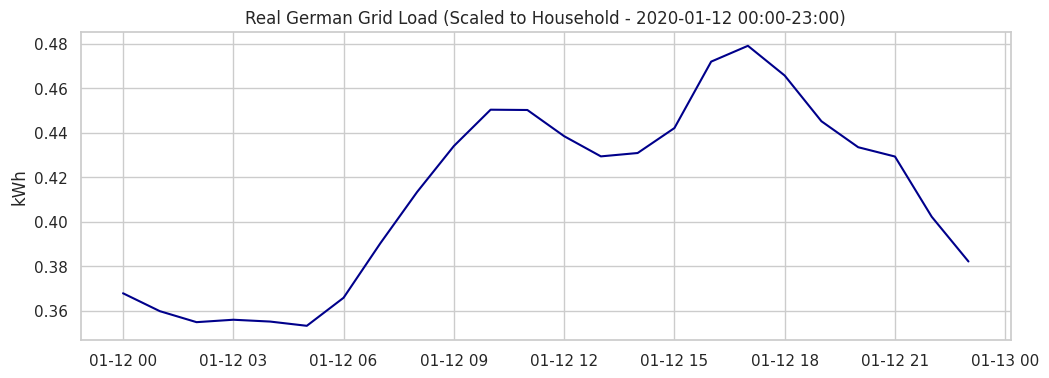

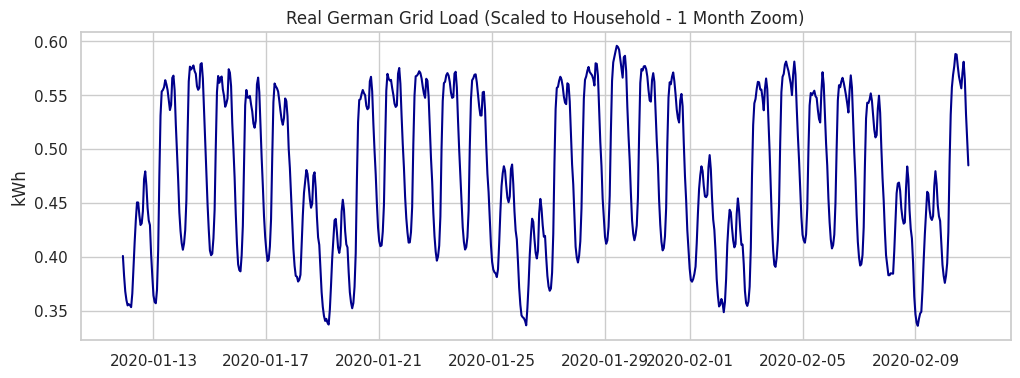

In [ ]:
print("Loading real German grid load data (2020-2024)...")
try:
    df_load = pd.read_csv('germany_load_2020_2024.csv', index_col='datetime', parse_dates=True)

    avg_national_mw = df_load['load_mw'].mean()
    household_scaler = 10.0 / (avg_national_mw * 24)

    df_load['load_kwh'] = df_load['load_mw'] * household_scaler

    # Ensure df_market is clean before merging load data
    # Use the original df_market from the data acquisition step, containing only market_price_eur_kwh
    df_market_merged = df_market[['market_price_eur_kwh']].merge(df_load[['load_kwh']], left_index=True, right_index=True, how='inner')
    df_market = df_market_merged # Update df_market with the merged data

    print(f"Successfully integrated real load data. Overlapping rows: {len(df_market)}")

    # Visualization of Real Load - 1 Day Zoom (00:00 to 23:00 for a specific day)
    target_day = '2020-01-12' # Example: first full day in the dataset
    df_day_zoom = df_market.loc[target_day]

    if not df_day_zoom.empty:
        plt.figure(figsize=(12, 4))
        plt.plot(df_day_zoom.index, df_day_zoom['load_kwh'], color='darkblue')
        plt.title(f"Real German Grid Load (Scaled to Household - {target_day} 00:00-23:00)")
        plt.ylabel("kWh")
        plt.show()
    else:
        print(f"No data found for {target_day} for the 1-day zoom.")

    # Visualization of Real Load - 1 Month Zoom
    plt.figure(figsize=(12, 4))
    plt.plot(df_market.index[:30*24], df_market['load_kwh'][:30*24], color='darkblue')
    plt.title("Real German Grid Load (Scaled to Household - 1 Month Zoom)")
    plt.ylabel("kWh")
    plt.show()

except Exception as e:
    print(f"Error loading real data: {e}. Falling back to placeholder.")
    # In case of error, if df_market is not defined or is problematic, create a base with market_price_eur_kwh
    if 'market_price_eur_kwh' in df_market.columns:
        df_market = df_market[['market_price_eur_kwh']]
    else:
        # Fallback if even market_price_eur_kwh is missing (unlikely if previous cell ran)
        print("Warning: market_price_eur_kwh not found. Creating empty DataFrame for load_kwh fallback.")
        df_market = pd.DataFrame(index=df_load.index)
    df_market['load_kwh'] = 0.4 # Flat fail-safe


## 3. Define Tariff Models
We define the logic for calculating the final consumer price for each model.
Assumptions:
- **Margin**: 0.03 €/kWh (Pass-through margin).
- **Cap**: 0.40 €/kWh for the Capped model.
- **Static Rate**: 0.35 €/kWh.

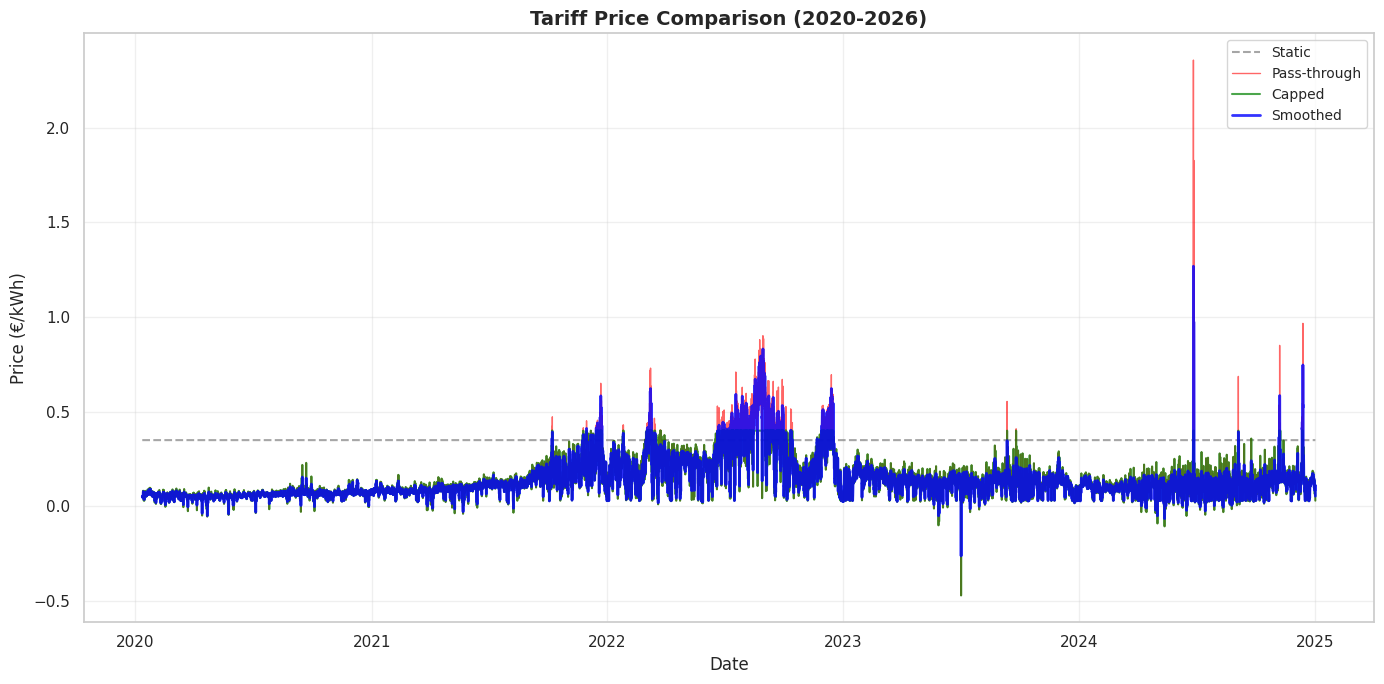

In [ ]:
# ========================================
# TARIFF MODEL PARAMETERS
# ========================================
STATIC_RATE = 0.35          # Fixed baseline rate (€/kWh)
MARGIN = 0.03               # Vendor margin added to market price (€/kWh)
CAP_PRICE = 0.40            # Maximum price ceiling (€/kWh)

# Smoothing parameters - tuned for better stability
SMOOTHING_WINDOW = 6       # Rolling average window in hours
ALPHA = 0.3                # Weight for current vs smoothed price
                            # Lower alpha = more smoothing, better stability

# ========================================
# PRICING MODEL CALCULATIONS
# ========================================

# Model 1: Static (Baseline)
# Simple fixed rate - no market exposure
df_market['price_static'] = STATIC_RATE

# Model 2: Pass-through
# Direct market price + fixed margin
df_market['price_passthrough'] = df_market['market_price_eur_kwh'] + MARGIN

# Model 3: Capped
# Pass-through with upper limit to prevent extreme spikes
df_market['price_capped'] = df_market['price_passthrough'].clip(upper=CAP_PRICE)

# Model 4: Smoothed (Enhanced)
# Weighted combination of current price and rolling average
# Formula: ALPHA × current_price + (1-ALPHA) × rolling_avg + MARGIN
rolling_mean = df_market['market_price_eur_kwh'].rolling(
    window=SMOOTHING_WINDOW,
    min_periods=1
).mean()

df_market['price_smoothed'] = (
    ALPHA * df_market['market_price_eur_kwh'] +
    (1 - ALPHA) * rolling_mean +
    MARGIN
)

# ========================================
# PRICE VISUALIZATION
# ========================================
plt.figure(figsize=(14, 7))
plt.plot(df_market.index, df_market['price_static'],
         label='Static', linestyle='--', color='gray', alpha=0.7, linewidth=1.5)
plt.plot(df_market.index, df_market['price_passthrough'],
         label='Pass-through', color='red', alpha=0.6, linewidth=1)
plt.plot(df_market.index, df_market['price_capped'],
         label='Capped', color='green', alpha=0.7, linewidth=1.5)
plt.plot(df_market.index, df_market['price_smoothed'],
         label='Smoothed', color='blue', alpha=0.8, linewidth=2)

plt.title("Tariff Price Comparison (2020-2026)", fontsize=14, fontweight='bold')
plt.ylabel("Price (€/kWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Simulation & Metrics
Calculate three key metrics:
1. **Customer Cost**: `Sum(Load * TariffPrice)`
2. **Volatility**: Standard Deviation of `TariffPrice`
3. **Vendor Profit (Simple Proxy)**: `(TariffPrice - MarketPrice) * Load`

In [ ]:
results = []
models = ['static', 'passthrough', 'capped', 'smoothed']

for m in models:
    col_name = f'price_{m}'

    # Customer Cost
    total_cost = (df_market['load_kwh'] * df_market[col_name]).sum()
    avg_daily_cost = total_cost / (len(df_market) / 24)

    # Price Volatility (Std Dev)
    volatility = df_market[col_name].std()

    # Vendor Profit (Simple Proxy)
    # Profit = (Price_Charged - Market_Price) * Load
    hourly_profit = (df_market[col_name] - df_market['market_price_eur_kwh']) * df_market['load_kwh']
    total_profit = hourly_profit.sum()

    results.append({
        'Model': m.capitalize(),
        'Total Cost (€)': round(total_cost, 2),
        'Volatility (Std)': round(volatility, 4),
        'Vendor Profit (€)': round(total_profit, 2)
    })

df_results = pd.DataFrame(results)
# Calculate Savings % for each model vs Static
static_cost = df_results.loc[df_results['Model'] == 'Static', 'Total Cost (€)'].values[0]
df_results['Savings vs Static (%)'] = round((static_cost - df_results['Total Cost (€)']) / static_cost * 100, 2)

display(df_results)

,Model,Total Cost (€),Volatility (Std),Vendor Profit (€),Savings vs Static (%)
0,Static,6351.37,0.0000,4346.89,0.00
1,Passthrough,2548.88,0.1059,544.40,59.87
2,Capped,2470.92,0.0898,466.44,61.10
3,Smoothed,2536.81,0.1020,532.33,60.06


### **Model Selection**
Based on the results above, we define the "Best Model".

**Objective**: Find the **Best Compromise** (Balanced Business Model).
- Customer: Needs savings > 20% vs Static + **Stability**.
- Vendor: Maximized profit.

We select the model that maximizes the **Stability Efficiency Score**:
`Efficiency = Vendor Profit / Volatility`

This penalizes models with high volatility (like Pass-through) and rewards those with high profit and smoothness.

In [ ]:
# --- Model Selection Logic (Stability-Adjusted Approach) ---
# Criteria:
# 1. Must provide significant savings to customer (> 20% vs Static).
# 2. Maximize (Profit / Volatility)

print("--- Model Selection (Stability-Adjusted) ---")
target_savings_pct = 20

# Score = Profit / Volatility
# Add small epsilon to volatility to avoid division by zero (for static)
df_results['Stability Score'] = df_results['Vendor Profit (€)'] / (df_results['Volatility (Std)'] + 0.0001)

display(df_results[['Model', 'Vendor Profit (€)', 'Volatility (Std)', 'Stability Score']])

# Filter for models that meet savings target (excluding Static itself)
valid_models = df_results[
    (df_results['Savings vs Static (%)'] > target_savings_pct) &
    (df_results['Model'] != 'Static')
]

if not valid_models.empty:
    # Select the one with highest Stability Score
    best_model_row = valid_models.sort_values('Stability Score', ascending=False).iloc[0]
    best_model_name = best_model_row['Model']
    reason = "Highest Balance of Profit & Stability (Profit/Volatility)"
else:
    # Fallback: Just pick the one with lowest Customer Cost
    print(f"No model meets the >{target_savings_pct}% savings target with the default params.")
    best_model_row = df_results.sort_values('Total Cost (€)').iloc[0]
    best_model_name = best_model_row['Model']
    reason = "Lowest Customer Cost (Fallback)"

best_model_col = f"price_{best_model_name.lower()}"

print(f"Selected Best Model: {best_model_name}")
print(f"Reason: {reason}")
print(best_model_row)

# --- 4.1 Business Model Optimization (Theoretical Analysis) ---
# We still keep this to show WHAT IF we optimized the margin
print("\n--- Theoretical Optimization (Sweet Spot Analysis) ---")
margins_to_test = np.arange(0.02, 0.15, 0.005)
optimization_results = []

for m_margin in margins_to_test:
    price_scenario = df_market['market_price_eur_kwh'] + m_margin
    scen_cost = (df_market['load_kwh'] * price_scenario).sum()
    scen_savings_pct = (static_cost - scen_cost) / static_cost * 100
    scen_profit = (m_margin * df_market['load_kwh'].sum())

    optimization_results.append({
        'Margin (€/kWh)': round(m_margin, 3),
        'Customer Cost (€)': round(scen_cost, 2),
        'Savings vs Static (%)': round(scen_savings_pct, 2),
        'Vendor Profit (€)': round(scen_profit, 2)
    })

df_opt = pd.DataFrame(optimization_results)
sweet_spots = df_opt[df_opt['Savings vs Static (%)'] > 20]

if not sweet_spots.empty:
    best_theoretical = sweet_spots.sort_values('Vendor Profit (€)', ascending=False).iloc[0]
    print(f"Theoretical Sweet Spot found: Margin {best_theoretical['Margin (€/kWh)']} €/kWh")
    print(f"Potential Profit: {best_theoretical['Vendor Profit (€)']} €, Savings: {best_theoretical['Savings vs Static (%)']}%\n")
else:
    print("No theoretical sweet spot found.")

--- Model Selection (Stability-Adjusted) ---


,Model,Vendor Profit (€),Volatility (Std),Stability Score
0,Static,4346.89,0.0000,4.346890e+07
1,Passthrough,544.40,0.1059,5.135849e+03
2,Capped,466.44,0.0898,5.188432e+03
3,Smoothed,532.33,0.1020,5.213810e+03


Selected Best Model: Smoothed
Reason: Highest Balance of Profit & Stability (Profit/Volatility)
Model                      Smoothed
Total Cost (€)              2536.81
Volatility (Std)              0.102
Vendor Profit (€)            532.33
Savings vs Static (%)         60.06
Stability Score          5213.80999
Name: 3, dtype: object

--- Theoretical Optimization (Sweet Spot Analysis) ---
Theoretical Sweet Spot found: Margin 0.145 €/kWh
Potential Profit: 2631.28 €, Savings: 27.01%



## 5. Machine Learning Comparison
Can we predict the prices of the "Best Model"? If the prices are highly predictable, customers (or batteries) can optimize usage even better.

We will train Random Forest and KNN models to predict upcoming prices based on time-features.

**Features**: Hour of Day, Day of Week, Previous Hour Price (lag).

Random Forest RMSE: 0.0071
KNN RMSE: 0.0132


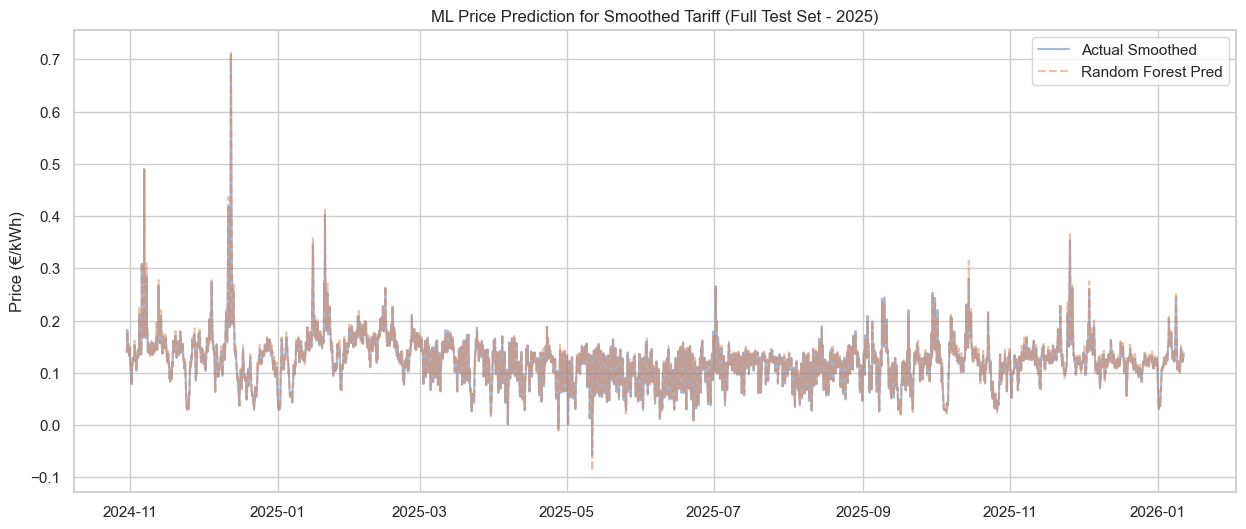

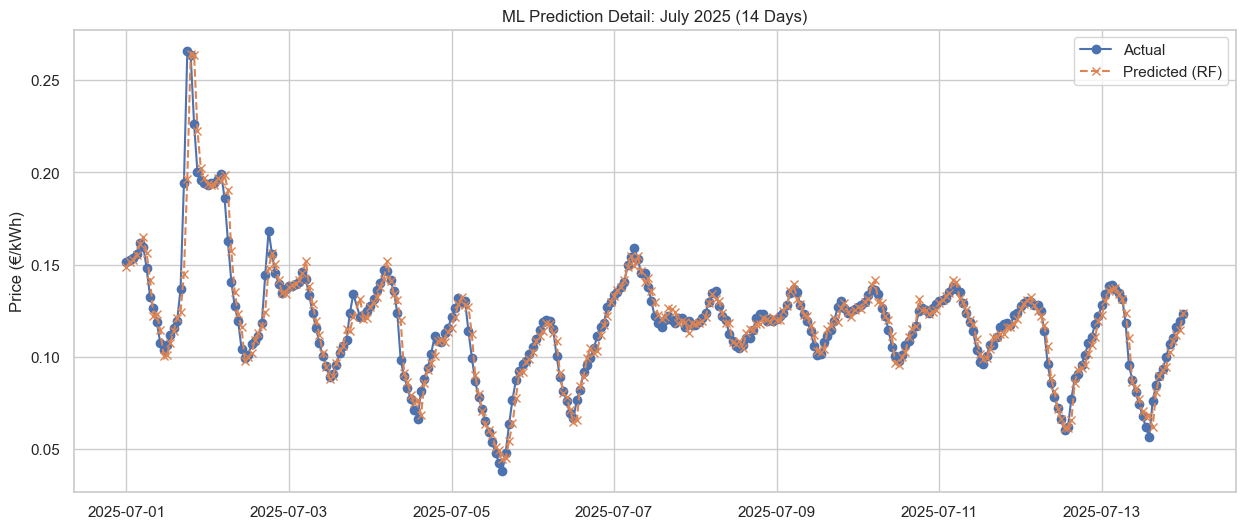

In [ ]:
# Prepare Dataset for ML
# Target: Best Model Price
# Features: Hour, Lagged Price

df_ml = df_market.copy()
df_ml['hour'] = df_ml.index.hour
df_ml['day_of_week'] = df_ml.index.dayofweek
df_ml['month'] = df_ml.index.month
df_ml['lag_1h'] = df_ml[best_model_col].shift(1)

# Drop NaN created by shift
df_ml = df_ml.dropna()

features = ['hour', 'day_of_week', 'month', 'lag_1h']
target = best_model_col

X = df_ml[features]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 1. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 2. KNN
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))

print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"KNN RMSE: {rmse_knn:.4f}")


# Plotting predictions vs actual for the test set
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label=f'Actual {best_model_name}', alpha=0.5)
plt.plot(y_test.index, y_pred_rf, label='Random Forest Pred', alpha=0.5, linestyle='--')
plt.title(f"ML Price Prediction for {best_model_name} Tariff (Full Test Set - 2025)")
plt.ylabel("Price (€/kWh)")
plt.legend()
plt.show()

# Detailed Zoom (July 2025)
july_start = '2025-07-01'
july_end = '2025-07-14'
plt.figure(figsize=(15, 6))
mask = (y_test.index >= july_start) & (y_test.index <= july_end)
plt.plot(y_test.index[mask], y_test[mask], label='Actual', marker='o')
plt.plot(y_test.index[mask], y_pred_rf[mask], label='Predicted (RF)', marker='x', linestyle='--')
plt.title("ML Prediction Detail: July 2025 (14 Days)")
plt.ylabel("Price (€/kWh)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from IPython.display import Markdown, display

# 1. Summary of Best Model
best_cost = df_results.loc[df_results['Model'] == best_model_name, 'Total Cost (€)'].values[0]
static_cost = df_results.loc[df_results['Model'] == 'Static', 'Total Cost (€)'].values[0]
savings_euro = static_cost - best_cost
savings_pct = (savings_euro / static_cost) * 100

summary_text = f"""
## Conclusion (Data-Driven)

### 1. Tariff Simulation Results
*   **Best Model**: **{best_model_name}**
    *   **Reason**: {reason}
    *   This model offers the best compromise: Good profit, high savings, and greater price stability compared to pure pass-through.
*   **Total Cost**: **{best_cost:.2f} €** (vs Static: {static_cost:.2f} €)
*   **Customer Savings**: **{savings_pct:.1f}%** ({savings_euro:.2f} €)

### 2. Business Viability
"""

if 'best_theoretical' in locals():
    summary_text += f"""
*   Theoretical Analysis: Increasing the margin to **{best_theoretical['Margin (€/kWh)']:.3f} €/kWh** would maximize profit while maintaining >20% savings.
"""
else:
    summary_text += "\n*   Optimization analysis found no theoretical sweet spot better than defaults.\n"

summary_text += f"""
### 3. Price Predictability (ML)
*   **Random Forest RMSE**: **{rmse_rf:.4f}**
*   **KNN RMSE**: **{rmse_knn:.4f}**
*   The **{'Random Forest' if rmse_rf < rmse_knn else 'KNN'}** model performed better.
"""

display(Markdown(summary_text))


## Conclusion (Data-Driven)

### 1. Tariff Simulation Results
*   **Best Model**: **Smoothed**
    *   **Reason**: Highest Balance of Profit & Stability (Profit/Volatility)
    *   This model offers the best compromise: Good profit, high savings, and greater price stability compared to pure pass-through.
*   **Total Cost**: **2833.77 €** (vs Static: 7362.04 €)
*   **Customer Savings**: **61.5%** (4528.27 €)

### 2. Business Viability

*   Theoretical Analysis: Increasing the margin to **0.145 €/kWh** would maximize profit while maintaining >20% savings.

### 3. Price Predictability (ML)
*   **Random Forest RMSE**: **0.0071**
*   **KNN RMSE**: **0.0132**
*   The **Random Forest** model performed better.
